In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def logprior(b, sigma2):
    return -np.log(sigma2)

def logistic(x, b):
    theta = linear(x,b)
    return 1.0/(1+np.exp(theta))

def linear(x, b):
    nFeat = x.shape[0]
    y = np.zeros(x.shape[1])
    for i in xrange(nFeat):
        y += x[i]*b[i+1]
    return b[0] + y
    #return b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3] + x[3]*b[4]

def loglikelihood(b, sigma2, x, y, model):
    n = len(x)
    return -n*np.log(sigma2) - 0.5*((y-model(x, b))**2).sum()/sigma2

def logpost(b, sigma2, x, y, model):
    return logprior(b, sigma2) + loglikelihood(b, sigma2, x, y, model)

In [5]:
# mcmc algorithm
def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e, model):
    nFeat = len(b_init) - 1
    
    B = np.zeros((N,nFeat + 1))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random(N)
    
    for i in xrange(N):
        b_star = np.random.normal(b_prev,be)

        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        
        p = logpost(b_star, sig2_star, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
        if np.log(r[i]) < p:
            b_prev = b_star
            sig2_prev = sig2_star
            count += 1
                           
        B[i] = b_prev
        Sig2[i] = sig2_prev
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return B, Sig2

In [6]:
def mcmcComp(b_init, sig2, x, y, N, burnin, be, sig2e, model):
    #MCMC with componentwise updating instead of block updating
    nParam = len(b_init)
    
    B = np.zeros((N,nParam))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random((N,nParam+1))
    
    for i in xrange(N):
        #updating all the beta parameters
        for j in xrange(nParam):
            b_star = np.copy(b_prev)
            b_star[j] = np.random.normal(b_prev[j],be[j])
            p = logpost(b_star, sig2_prev, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
            if np.log(r[i,j]) < p:
                b_prev = b_star
                count += 1
        
        #updating sig2
        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        p = logpost(b_prev, sig2_star, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
        if np.log(r[i,-1]) < p:
            sig2_prev = sig2_star
            count += 1
        B[i] = b_prev
        Sig2[i] = sig2_prev
        
    print "The acceptance rate is "+ str(float(count)/(N*(nParam+1)))+"."
    return B, Sig2

In [7]:
def import_data():
    #import data and labels
    train_data = pd.read_csv('Waterpump-training-values.csv')
    train_labels = pd.read_csv('Waterpump-training-labels.csv')
    
    #separating dataset into training and testing for cross-validation - 90% into training
    test_idx = np.random.uniform(0, 1, len(train_data)) <= 0.9
    train = train_data[test_idx==True]
    trainLabels = train_labels[test_idx==True]
    test = train_data[test_idx==False]
    testLabels = train_labels[test_idx==False]
    
    return train, trainLabels, test, testLabels

In [42]:
def processAllData(train, trainLabels, test, testLabels):
    
    train, nFeatures = processData(train)
    test, _ = processData(test)
    
    trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
    trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']
    
    return train, trainLabelsVect, test, testLabels, nFeatures

def processData(data):
    features = ['longitude', 'latitude', 'age', 'gps_height', 'dry', 'population']
    nFeatures = len(features)
    data['age'] = 2015 - data['construction_year']
    data['dry'] = data['quantity'] == 'dry'
    return np.transpose(data[features].values), nFeatures

In [15]:
train, trainLabels, test, testLabels = import_data()
train, trainLabels, test, testLabels, nFeatures = processAllData(train, trainLabels, test, testLabels)

In [16]:
numBeta = nFeatures + 1  #1 more for the constant

In [26]:
#blockwise updating
model = logistic
b_init = [-0.5, 0, 0, 0, 0, 4, 0]
be = [0.01, 0.001, 0.001, 0.001, 0.001, 0.05, 0.001]
B, sig2= mcmc(b_init, 10, train, trainLabels['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.011.


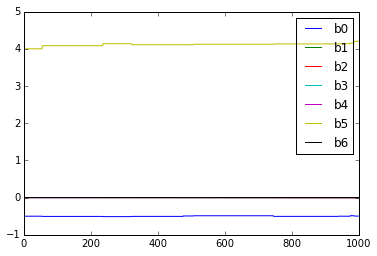

In [27]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()

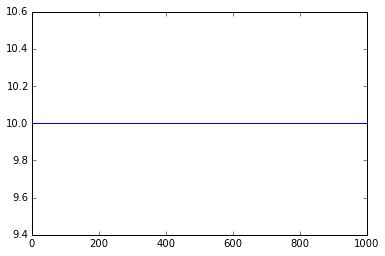

In [19]:
plt.plot(sig2)

In [108]:
b_final = B[-1,:]

In [86]:
b_final

array([  1.71770911e+00,   2.18640660e-04,  -4.22197508e-04,
        -6.64113238e+00,   1.10874746e+00])

In [109]:
#predictions - these are the continuous values, need to convert to labels
yPredict = model(test, b_final)

In [110]:
n = len(testLabels)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.651818485152


(array([  387.,   346.,   297.,   259.,   275.,   314.,   507.,   527.,
          761.,  2321.]),
 array([ 0.00702402,  0.10604868,  0.20507335,  0.30409801,  0.40312268,
         0.50214734,  0.601172  ,  0.70019667,  0.79922133,  0.89824599,
         0.99727066]),
 <a list of 10 Patch objects>)

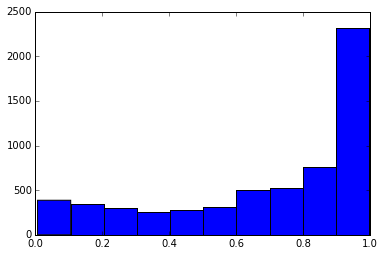

In [111]:
plt.hist(yPredict)

In [20]:
#using componentwise updating
model = logistic
b_init = [0.5, 0, 0, 0, 0, 2, 0]
be = [0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
B, sig2= mcmcComp(b_init, 10, train, trainLabels['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.356125.


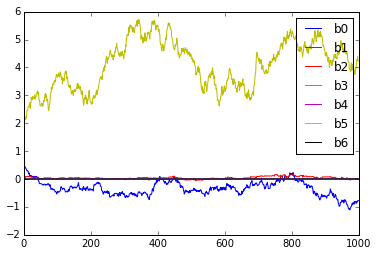

In [21]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()

In [22]:
b_final = B[-1,:]
#predictions - these are the continuous values, need to convert to labels
yPredict = model(test, b_final)
n = len(testLabels)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.606035345115


In [36]:
def processAllData(train, trainLabels, test, testLabels):
    
    train, nFeatures = processData2(train)
    test, _ = processData2(test)
    
    trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
    trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']
    
    return train, trainLabelsVect, test, testLabels, nFeatures

def processData2(data):
    features = ['longitude', 'latitude', 'lat2', 'lon2', 'dry', 'population']
    nFeatures = len(features)
    data['age'] = 2015 - data['construction_year']
    data['dry'] = data['quantity'] == 'dry'
    data['lon2'] = data['longitude']**2
    data['lat2'] = data['latitude']**2
    return np.transpose(data[features].values), nFeatures

In [37]:
train, trainLabels, test, testLabels = import_data()
train2, trainLabels2, test2, testLabels2, nFeatures2 = processAllData(train, trainLabels, test, testLabels)

In [38]:
#using componentwise updating
model = logistic
b_init = [-0.5, 0, 0, 0, 0, 4, 0]
be = [0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
B, sig2= mcmcComp(b_init, 10, train2, trainLabels2['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.360875.


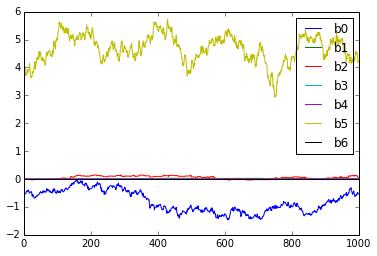

In [39]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()

In [41]:
b_final = B[-1,:]
#predictions - these are the continuous values, need to convert to labels
yPredict = model(test2, b_final)
n = len(testLabels2)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels2['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.352563018102


In [43]:
train, trainLabels, test, testLabels = import_data()
train1, trainLabels1, test1, testLabels1, nFeatures1 = processAllData(train, trainLabels, test, testLabels)

In [47]:
#blockwise updating
model = linear
b_init = [-0.5, 0, 0, 0, 0, 4, 0]
be = [0.01, 0.001, 0.001, 0.001, 0.001, 0.05, 0.001]
B, sig2= mcmcComp(b_init, 10, train1, trainLabels1['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.48775.


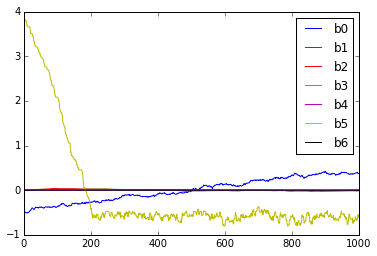

In [48]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()